# **Bibliotecas e Tratamentos de dados**
Nessa momento será importado as bilbiotecas e arquivos necessários para a análise.

Será aplicado otimizações nos formatos das variáveis para diminuir o custo de processamento.

Além de ser feitos tratamentos de texto para obtermos informações como:
- Ano de lançamento dos filmes.
- O período que abrange os dados dessa base.
- Quais gêneros existem na base do Movie Lens e quais são os gêneros mais frequentes.

In [29]:
#Importando as bibliotecas
from IPython.display import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
#Importando as bases com os tipos otimizados
movies = pd.read_csv("movies.csv",
                     dtype={"movieId":"int32"})

ratings = pd.read_csv("ratings.csv",
                      usecols=["movieId", "rating", "timestamp"],
                      dtype={"movieId":"int32",
                             "rating":"float32",
                             "timestamp":"int32"})

In [31]:
#Visualizando as bases
print("Movies dataset")
display(movies.head())
print("Ratings dataset")
display(ratings.head())

Movies dataset


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings dataset


,movieId,rating,timestamp
0,296,5.0,1147880044
1,306,3.5,1147868817
2,307,5.0,1147868828
3,665,5.0,1147878820
4,899,3.5,1147868510


In [32]:
#Extraindo o ano do filme da coluna "title" para a coluna "year"
movies["year"] = movies["title"].str.extract(r'\((19[0-9][0-9]|20[0-9][0-9])\)')

In [33]:
#Alguns filmes não tinha o ano de lançamento junto do nome para extrairmos, depois vamos remover essas linhas porque são poucas
movies.isnull().sum()

movieId      0
title        0
genres       0
year       527
dtype: int64

In [34]:
#Criando uma matriz para transformar a lista de gêneros em colunas
generos = []

#Separando os gêneros
for genero in movies["genres"]:
    generos.extend(genero.split("|"))
    generos

#Identificando os valores únicos para os gêneros não se repetirem    
generos = pd.unique(generos)

#Criando uma matriz no numpy de zeros com a extensão do df de movies (linhas) e gêneros (colunas)
matriz = np.zeros((len(movies), len(generos)))

#Criando um df com a matriz do numpy
dummies = pd.DataFrame(matriz, columns=generos)

#Populando o df de gêneros, indentificando as linhas que possuem determinado gêneros
for i, gen in enumerate(movies["genres"]):
    indeces = dummies.columns.get_indexer(gen.split("|"))
    dummies.iloc[i, indeces] = 1

C:\Users\Computador\AppData\Local\Temp\ipykernel_3092\2506874327.py:10: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  generos = pd.unique(generos)


In [35]:
#Juntando o df de gêneros ao df movies para forma um novo df
movies_genre = movies.join(dummies)

In [36]:
#Oitmizando as colunas de gêneros para um formato mais simples
movies_genre[movies_genre.columns[4:]] = movies_genre[movies_genre.columns[4:]].astype("int8")

In [37]:
#Removendo os filmes que não tinham o ano definido
movies_genre.dropna(subset="year", inplace=True)
movies_genre["year"] = movies_genre["year"].astype("int16")

In [38]:
#Removendo os filmes de 2019 porque parece que esse ano ainda não terminou
movies_genre = movies_genre[movies_genre["year"] != 2019]

# **Insights Gerais**
Nessa aba é apresentado informações gerais sobre a base do Movie Lens, como:
- Quantidade de filmes lançados entre 1900 e 2018.
- Gêneros com mais filmes entre 1900 e 2018.
- Gêneros mais relevantes ao longo dos anos.

**INSIGHTS**
- A popularização do cinema ao decorrer do tempo trouxe mais filmes lançados, principalmente nos anos mais recentes que houve maior acesso as tecnologias para gravações, edições e meios publicação de filmes.
- Considerando filmes entre 1900 e 2018, os gêneros mais comuns são Drama, Comédia, Suspense, Romance e Ação.


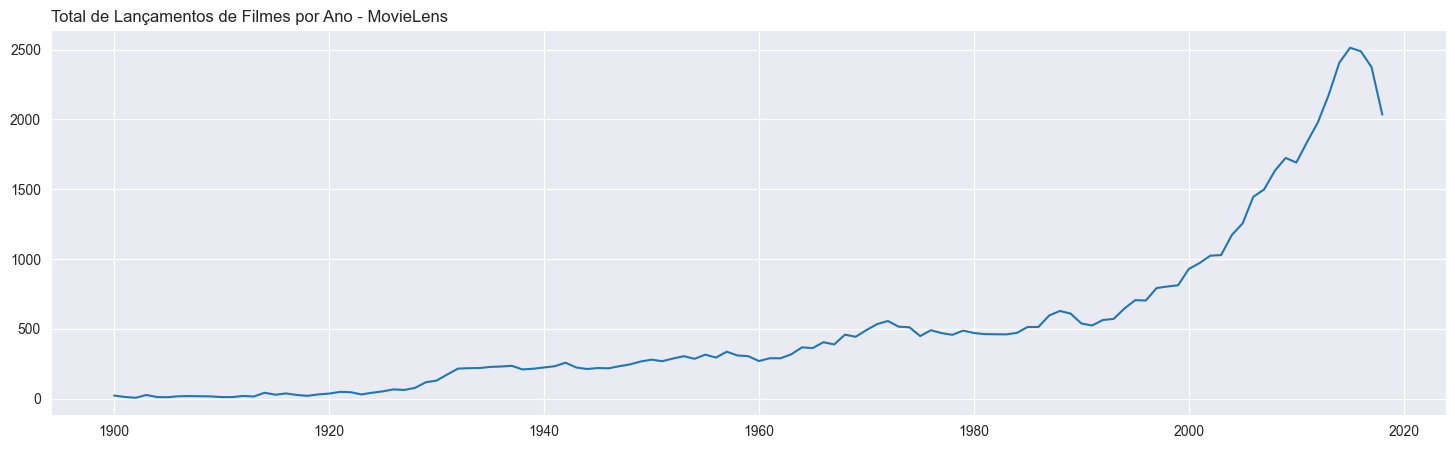

In [56]:
grafico = movies_genre["year"].value_counts().sort_index()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.lineplot(grafico)
_ = plt.title("Total de Lançamentos de Filmes por Ano - MovieLens", loc="left")
_ = plt.xlabel("")
_ = plt.ylabel("")

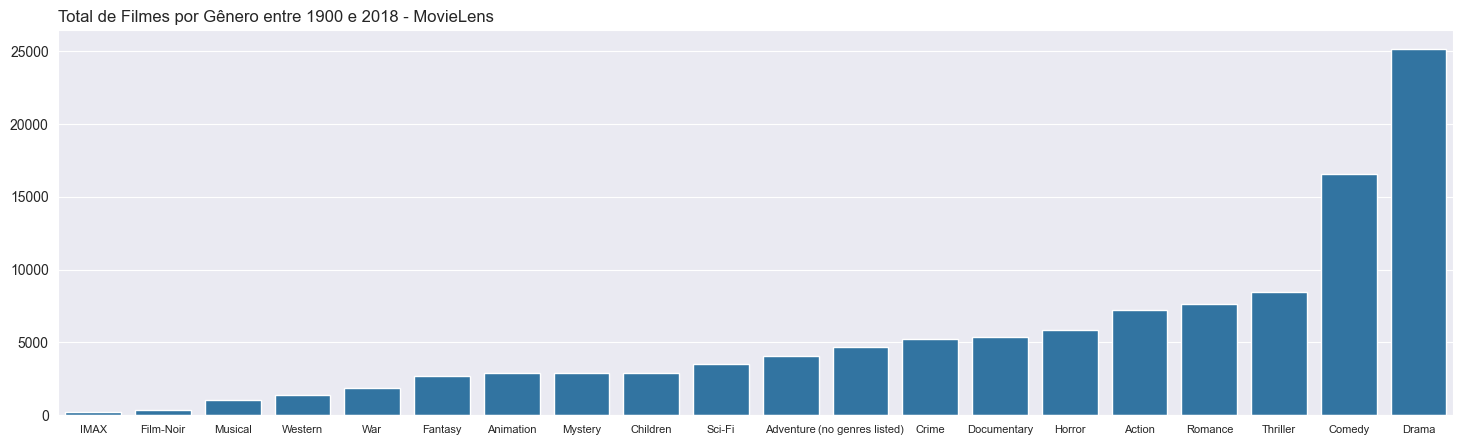

In [40]:
grafico = movies_genre[movies_genre.columns[4:]].sum().sort_values()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.barplot(grafico)
_ = plt.title("Total de Filmes por Gênero entre 1900 e 2018 - MovieLens", loc="left")
_ = plt.xlabel("")
_ = plt.xticks(fontsize=8)
_ = plt.ylabel("")

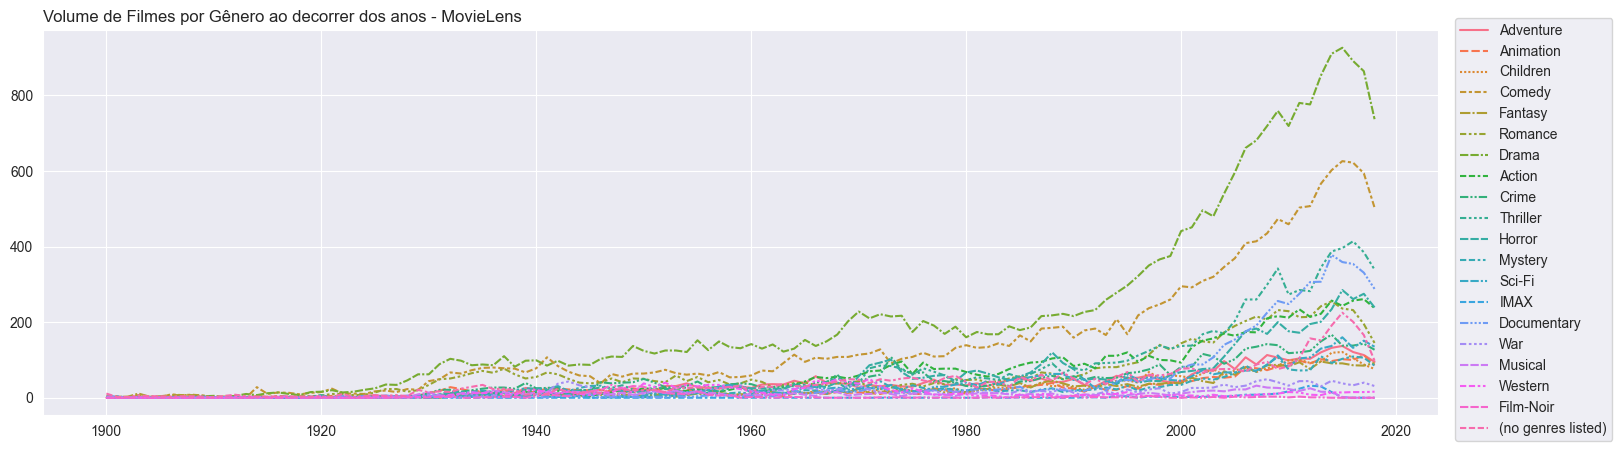

In [57]:
grafico = movies_genre.groupby("year")[movies_genre.columns[4:]].sum()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.lineplot(grafico)
_ = plt.title("Volume de Filmes por Gênero ao decorrer dos anos - MovieLens", loc="left")
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.legend(loc="upper right", bbox_to_anchor=(1.13, 1.05))

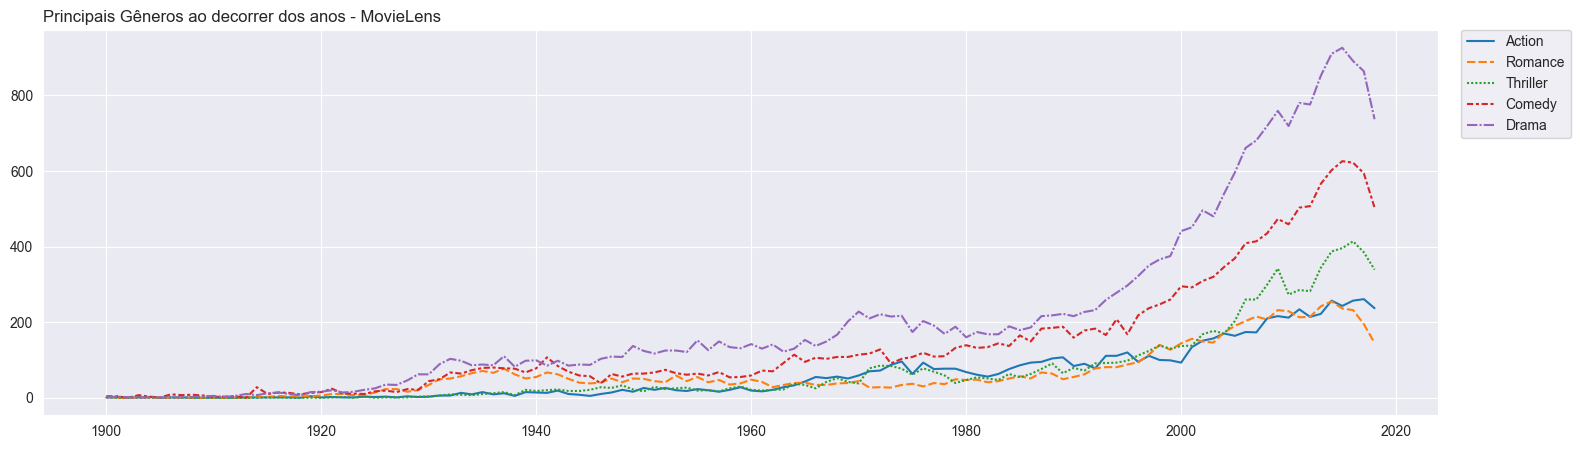

In [69]:
filmes = movies_genre[movies_genre.columns[4:]].sum().sort_values()[-5:].index
filmes = filmes.insert(0, "year")

grafico = movies_genre[filmes].groupby("year").sum()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.lineplot(grafico)
_ = plt.title("Principais Gêneros ao decorrer dos anos - MovieLens", loc="left")
_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.02))

# **Cruzando as bases de Filmes e Notas**
Nesse momento serão cruzados as infomações de filmes com as notas esses filmes receberam ao longo do tempo, mas para isso é necessário agrupar as informações da base de notas. A base de notas está bastante granular, mostrando quando cada voto foi gerado dentro do Movie Lens, sendo necessário agrupar essas informações para cruzar as bases.

Também será verificado a quantidade votos que cada filme teve. 

**SPOILER**: aproximadamente 93% dos filmes tiveram menos 1.000 votos, mostrando que pelo menos no Movie Lens, não há tanto engajamento do público votar nos filmes.

In [43]:
#Agrupando as notas por filme, tendo a quantidade de votos, nota média, nota mínima e nota máxima
ratings_agg = ratings.groupby("movieId").agg({"rating":{"count", "mean", "min", "max"}})

In [44]:
#Removendo os níveis do indíce para cruzar com a base de filmes
ratings_agg.columns = ratings_agg.columns.droplevel()
ratings_agg.reset_index(inplace=True)

#Arredondando a nota média
ratings_agg["mean"] = ratings_agg["mean"].round(1)

In [45]:
#Cruzando as bases
movies_ratings = pd.merge(movies_genre, ratings_agg, on="movieId", how="inner")

**Investigando a quantidade notas por filme**

In [46]:
#Verificando o share pela quantidade de votos que os filems possuem
movies_ratings["count"].sort_values().value_counts(normalize=True)

count
1        0.171855
2        0.129104
3        0.082966
4        0.058767
5        0.042282
           ...   
3222     0.000017
3225     0.000017
3243     0.000017
3248     0.000017
81491    0.000017
Name: proportion, Length: 3817, dtype: float64

In [47]:
print("Infelizmente, mais da metade dos filmes da base possuem poucos votos.")
print(f"Considerando os filmes que tem até 10 votos, estes representam: {round((len(movies_ratings[movies_ratings['count'] < 11]) / len(movies_ratings)) *100, 2)}% da base de filmes.")
print(f"Se considerarmos o que possuem mais de 1.000 votos, o share aumenta para {round((len(movies_ratings[movies_ratings['count'] < 1001]) / len(movies_ratings)) *100, 2)}%.")
print(f"Para montar alguns gráficos com notas, vou trabalhar apenas com filmes com mais de 1.000 votos.")

Infelizmente, mais da metade dos filmes da base possuem poucos votos.
Considerando os filmes que tem até 10 votos, estes representam: 60.01% da base de filmes.
Se considerarmos o que possuem mais de 1.000 votos, o share aumenta para 93.43%.
Para montar alguns gráficos com notas, vou trabalhar apenas com filmes com mais de 1.000 votos.


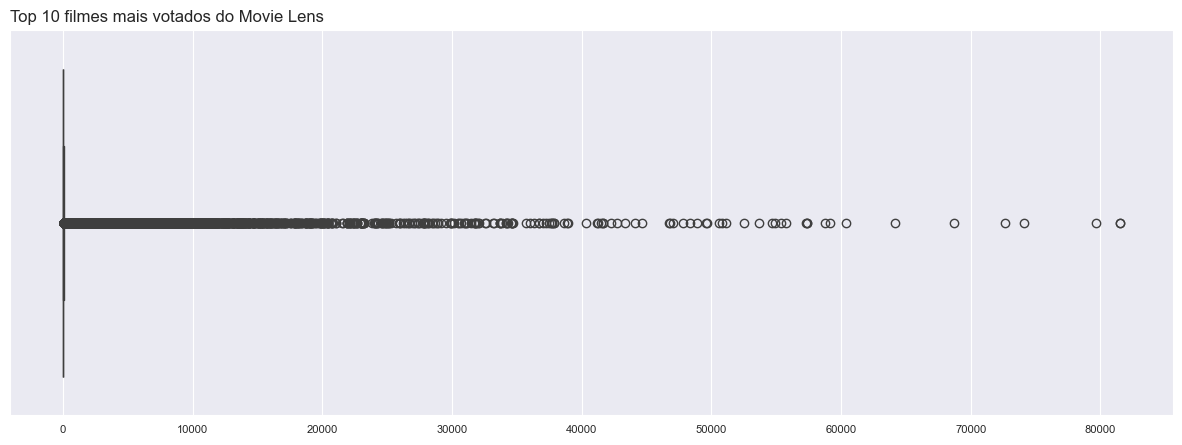

In [48]:
#Forma mais visual para ver a distribuição
sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(15, 5))

_ = sns.boxplot(data= movies_ratings, x="count")
_ = plt.title("Distribuição dos Filmes pela quantidade de notas", loc="left")
_ = plt.xlabel("")
_ = plt.xticks(fontsize=8)
_ = plt.ylabel("")

In [49]:
#Filtrando a base com filmes com mais de 1.000 votos
movies_ratings = movies_ratings[movies_ratings['count'] >= 1000]

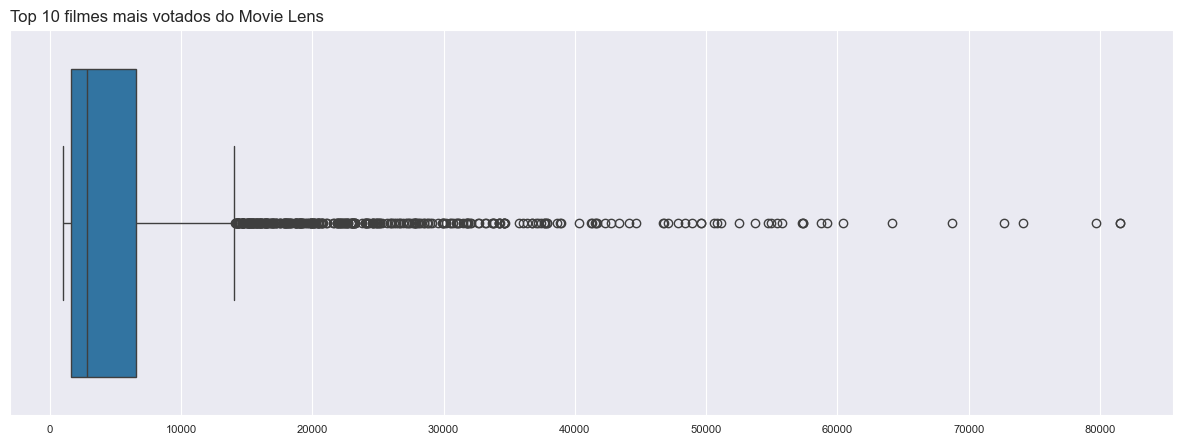

In [50]:
#Forma mais visual para ver a distribuição
sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(15, 5))

_ = sns.boxplot(data= movies_ratings, x="count")
_ = plt.title("Distribuição dos Filmes pela quantidade de notas, apenas filmes com mais 1.000 votos", loc="left")
_ = plt.xlabel("")
_ = plt.xticks(fontsize=8)
_ = plt.ylabel("")

# **Top Rankings de todos os tempos do Movie Lens**
Essa seção é rápida, apenas mostrando algumas visualizações possívels sobre rakings de filmes após ao cruzamento das bases de filmes e notas.

**INSIGHTS**
- **Filmes mais votados**
    - Forest Gump (1994), Um Sonho de Liberdade (1994), Pulp Fiction (1994), O Silêncio dos Inocentes (1991) e Matrix (1999).
    - Interessante como filmes da década de 1990 são os mais votados da plataforma e os três primeiros são de 1994!
- **Filmes com maior nota média**
    - Planet Earth I (2006) e II (2016), Um Sonho de Liberdade (1994), Um Sonho de Liberdade (1994), Band of Brothers (2001) e Os Suspeitos (1995).
    - Os Planet Earth são documentários produzidos pela BBC trantando sobre temas relacionados a natureza.
- **Principais Filmes por Gênero**
    - Deixo para vocês darem uma olhadinha. ;)

In [51]:
print("Top 5 Filmes MAIS VOTADOS do Movie Lens")
display(movies_ratings.loc[movies_ratings["count"].nlargest(5).index][["title", "count"]]),
print("Top 5 Filmes com MAIOR nota média Movie Lens")
display(movies_ratings.loc[movies_ratings["mean"].nlargest(5).index][["title", "count", "mean"]]),
print("Top 5 Filmes com MENOR nota média Movie Lens")
display(movies_ratings.loc[movies_ratings["mean"].nsmallest(5).index][["title", "count", "mean"]])

Top 5 Filmes MAIS VOTADOS do Movie Lens


,title,count
351,Forrest Gump (1994),81491
314,"Shawshank Redemption, The (1994)",81482
292,Pulp Fiction (1994),79672
585,"Silence of the Lambs, The (1991)",74127
2480,"Matrix, The (1999)",72674


Top 5 Filmes com MAIOR nota média Movie Lens


,title,count,mean
38217,Planet Earth (2006),1747,4.5
42732,Planet Earth II (2016),1124,4.5
314,"Shawshank Redemption, The (1994)",81482,4.4
42587,Band of Brothers (2001),1356,4.4
49,"Usual Suspects, The (1995)",55366,4.3


Top 5 Filmes com MENOR nota média Movie Lens


,title,count,mean
11349,Epic Movie (2007),1180,1.5
3494,Battlefield Earth (2000),4268,1.6
2464,Baby Geniuses (1999),1377,1.7
6359,Dumb and Dumberer: When Harry Met Lloyd (2003),1871,1.7
794,Kazaam (1996),1842,1.8


In [52]:
tabela = movies_ratings[movies_ratings["Action"] == 1]
print("Top 5 Filmes de Ação com MAIOR nota média Movie Lens")
display(tabela.loc[tabela["mean"].nlargest(5).index][["title", "count", "mean"]]),

tabela = movies_ratings[movies_ratings["Comedy"] == 1]
print("Top 5 Filmes de Comédia com MAIOR nota média Movie Lens")
display(tabela.loc[tabela["mean"].nlargest(5).index][["title", "count", "mean"]]),

tabela = movies_ratings[movies_ratings["Drama"] == 1]
print("Top 5 Filmes de Drama com MAIOR nota média Movie Lens")
display(tabela.loc[tabela["mean"].nlargest(5).index][["title", "count", "mean"]]),

tabela = movies_ratings[movies_ratings["Romance"] == 1]
print("Top 5 Filmes de Romance com MAIOR nota média Movie Lens")
display(tabela.loc[tabela["mean"].nlargest(5).index][["title", "count", "mean"]]),

tabela = movies_ratings[movies_ratings["Thriller"] == 1]
print("Top 5 Filmes de Suspense com MAIOR nota média Movie Lens")
display(tabela.loc[tabela["mean"].nlargest(5).index][["title", "count", "mean"]])

Top 5 Filmes de Ação com MAIOR nota média Movie Lens


,title,count,mean
42587,Band of Brothers (2001),1356,4.4
1930,Seven Samurai (Shichinin no samurai) (1954),13367,4.3
887,North by Northwest (1959),16850,4.2
2480,"Matrix, The (1999)",72674,4.2
2867,Fight Club (1999),58773,4.2


Top 5 Filmes de Comédia com MAIOR nota média Movie Lens


,title,count,mean
292,Pulp Fiction (1994),79672,4.2
734,Dr. Strangelove or: How I Learned to Stop Worr...,26714,4.2
929,"Thin Man, The (1934)",3318,4.2
2233,Life Is Beautiful (La Vita è bella) (1997),23976,4.2
600,Fargo (1996),47823,4.1


Top 5 Filmes de Drama com MAIOR nota média Movie Lens


,title,count,mean
314,"Shawshank Redemption, The (1994)",81482,4.4
42587,Band of Brothers (2001),1356,4.4
840,"Godfather, The (1972)",52498,4.3
1190,"Godfather: Part II, The (1974)",34188,4.3
1930,Seven Samurai (Shichinin no samurai) (1954),13367,4.3


Top 5 Filmes de Romance com MAIOR nota média Movie Lens


,title,count,mean
887,North by Northwest (1959),16850,4.2
891,Casablanca (1942),26890,4.2
901,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),7368,4.2
909,Notorious (1946),5062,4.2
2233,Life Is Beautiful (La Vita è bella) (1997),23976,4.2


Top 5 Filmes de Suspense com MAIOR nota média Movie Lens


,title,count,mean
49,"Usual Suspects, The (1995)",55366,4.3
292,Pulp Fiction (1994),79672,4.2
585,"Silence of the Lambs, The (1991)",74127,4.2
883,Rear Window (1954),20162,4.2
887,North by Northwest (1959),16850,4.2


# **Como foi o cinema em 2018?**
2018 é o ano mais recente dessa base de dados, apresentando um pouco das visualizações anteriores para apenas este ano.

**INSIGHTS**
- Apenas 19 filmes em 2018 que possuem mais de 1.000 votos no Movie Lens.
- Um pouco diferente do agrupamento geral, em 2018, os gêneros mais importantes foram Ação, Sci-fi e Aventura.
- Esse ano foi destaque em notas para os filmes de HQs, com **Homem-Aranha no Aranha Verso** com a maior nota, **Vingadores Guerra Infinita Parte I** em 3° e **Deadpool 2** em 6°.

In [53]:
movies_2018 = movies_ratings[movies_ratings["year"] == 2018]

movies_2018.shape

(19, 28)

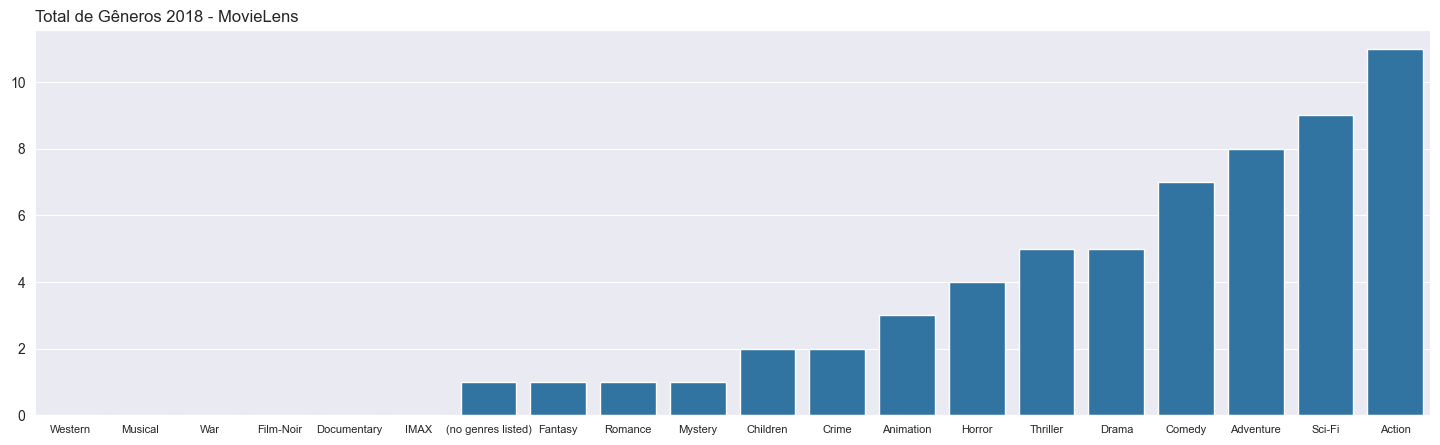

In [54]:
#Verificando a quantidade de filmes por gênero

grafico = movies_2018[movies_2018.columns[4:-4]].sum().sort_values()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.barplot(grafico)
_ = plt.title("Total de Gêneros 2018 - MovieLens", loc="left")
_ = plt.xlabel("")
_ = plt.xticks(fontsize=8)
_ = plt.ylabel("")

In [55]:
print("Nota Média dos Filmes de 2018 com Mais de 1.000 Votos")
display(movies_2018.sort_values(by="mean", ascending=False)[["title", "count", "mean"]])

Nota Média dos Filmes de 2018 com Mais de 1.000 Votos


,title,count,mean
53228,Spider-Man: Into the Spider-Verse (2018),3085,4.1
48371,Isle of Dogs (2018),2098,3.9
24539,Avengers: Infinity War - Part I (2018),6031,3.9
52914,Green Book (2018),1971,3.9
48360,Hereditary (2018),1313,3.8
49982,Deadpool 2 (2018),4249,3.8
50685,Upgrade (2018),1049,3.8
52178,Bohemian Rhapsody (2018),2151,3.7
48865,A Quiet Place (2018),2276,3.7
49957,Incredibles 2 (2018),2870,3.7
